In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading in full data set
# brfss_total = pd.read_csv("../csv_data/brfss_total.csv")
brfss_total = pd.read_csv("./brfss_total.csv")

In [5]:
brfss_total.head()

,Unnamed: 0,_STATE,DISPCODE,PHYSHLTH,MENTHLTH,USENOW3,HISPANC2,MARITAL,CHILDREN,EMPLOY,RENTHOM1,SEX,QLACTLM2,ACEDEPRS,ACEDRINK,ACEDRUGS,ACEPRISN,ACEDIVRC,ACEPUNCH,ACEHURT,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX,MSCODE,_IMPAGE,_RFHLTH,_SMOKER3,_PRACE,_EDUCAG,_INCOMG,_TOTINDA
0,0,5.0,110.0,0.0,0.0,3.0,2.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,53.0,1.0,4.0,1.0,3.0,5.0,1.0
1,1,5.0,110.0,15.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,5.0,64.0,2.0,3.0,1.0,2.0,2.0,1.0
2,2,5.0,110.0,6.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,58.0,1.0,4.0,1.0,3.0,2.0,1.0
3,3,5.0,110.0,30.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,76.0,2.0,4.0,1.0,1.0,0.0,2.0
4,4,5.0,110.0,13.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,5.0,82.0,2.0,3.0,1.0,2.0,0.0,2.0


In [6]:
# just making sure no nulls are present
brfss_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117555 entries, 0 to 117554
Data columns (total 32 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  117555 non-null  int64  
 1   _STATE      117555 non-null  float64
 2   DISPCODE    117555 non-null  float64
 3   PHYSHLTH    117555 non-null  float64
 4   MENTHLTH    117555 non-null  float64
 5   USENOW3     117555 non-null  float64
 6   HISPANC2    117555 non-null  float64
 7   MARITAL     117555 non-null  float64
 8   CHILDREN    117555 non-null  float64
 9   EMPLOY      117555 non-null  float64
 10  RENTHOM1    117555 non-null  float64
 11  SEX         117555 non-null  float64
 12  QLACTLM2    117555 non-null  float64
 13  ACEDEPRS    117555 non-null  float64
 14  ACEDRINK    117555 non-null  float64
 15  ACEDRUGS    117555 non-null  float64
 16  ACEPRISN    117555 non-null  float64
 17  ACEDIVRC    117555 non-null  float64
 18  ACEPUNCH    117555 non-null  float64
 19  AC

In [7]:
brfss_total.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
np.random.seed(151)

In [9]:
# creating X variable with all features
X_all = brfss_total.drop(columns=['USENOW3', 'QLACTLM2', '_RFHLTH', '_SMOKER3'])

In [10]:
# creating the 4 y's
y_tobacco = brfss_total['USENOW3']
y_activity = brfss_total['QLACTLM2']
y_health = brfss_total['_RFHLTH']
y_smoker = brfss_total['_SMOKER3']

In [11]:
#original baseline for tobacco
y_tobacco.value_counts(normalize=True)

3.0    0.966560
1.0    0.017872
2.0    0.012990
0.0    0.002578
Name: USENOW3, dtype: float64

In [12]:
#original baseline for activity
y_activity.value_counts(normalize=True)

2.0    0.724520
1.0    0.268997
0.0    0.006482
Name: QLACTLM2, dtype: float64

In [13]:
#original baseline for health
y_health.value_counts(normalize=True)

1.0    0.814742
2.0    0.181991
0.0    0.003267
Name: _RFHLTH, dtype: float64

In [14]:
#original baseline for smoker
y_smoker.value_counts(normalize=True)

4.0    0.521569
3.0    0.308324
1.0    0.119604
2.0    0.044226
0.0    0.006278
Name: _SMOKER3, dtype: float64

In [15]:
# splitting X up so I can do some engineering on the nominal data and ACE columns
X_num = X_all[['PHYSHLTH', 'MENTHLTH', 'CHILDREN']]
X_cat = X_all[['_STATE', 'DISPCODE', 'HISPANC2', 'MARITAL', 'EMPLOY', 'RENTHOM1', 'SEX', 'MSCODE', 
               '_IMPAGE', '_PRACE', '_EDUCAG', '_INCOMG','_TOTINDA']]
ace = X_all[['ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEDIVRC', 'ACEPUNCH', 'ACEHURT', 'ACESWEAR', 
                       'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']]

In [16]:
# updating ACE columns to be a count depending on the question
# first 5 questions are yes or no, so yes will be be counted as 1 and no will be counted as 0
# last 6 are questions of frequency, never = 0, once = 1, more than once = 2 (since not given an exact number)
ace['ACEDEPRS'] = ace['ACEDEPRS'].map({1:1, 2:0, 0:0})
ace['ACEDRINK'] = ace['ACEDRINK'].map({1:1, 2:0, 0:0})
ace['ACEDRUGS'] = ace['ACEDRUGS'].map({1:1, 2:0, 0:0})
ace['ACEPRISN'] = ace['ACEPRISN'].map({1:1, 2:0, 0:0})
ace['ACEDIVRC'] = ace['ACEDIVRC'].map({1:1, 2:0, 0:0})
ace['ACEPUNCH'] = ace['ACEPUNCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHURT'] = ace['ACEHURT'].map({1:0, 2:1, 3:2, 0:0})
ace['ACESWEAR'] = ace['ACESWEAR'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETOUCH'] = ace['ACETOUCH'].map({1:0, 2:1, 3:2, 0:0})
ace['ACETTHEM'] = ace['ACETTHEM'].map({1:0, 2:1, 3:2, 0:0})
ace['ACEHVSEX'] = ace['ACEHVSEX'].map({1:0, 2:1, 3:2, 0:0})

In [17]:
# creating a column for counting the number of ACEs an individual had
X_num['ACE_Count'] = ace.sum(axis = 1)

In [18]:
# turning the nominal columns into strings so they can be dummified
X_cat = X_cat.astype(str)

In [19]:
# dummifying nominal variables for X_all
X_dummies = pd.get_dummies(X_cat, drop_first=True)
X_dummies.head()

,_STATE_15.0,_STATE_19.0,_STATE_22.0,_STATE_27.0,_STATE_30.0,_STATE_32.0,_STATE_37.0,_STATE_40.0,_STATE_47.0,_STATE_5.0,_STATE_50.0,_STATE_53.0,_STATE_55.0,DISPCODE_1100.0,DISPCODE_120.0,DISPCODE_1200.0,HISPANC2_1.0,HISPANC2_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,EMPLOY_1.0,EMPLOY_2.0,EMPLOY_3.0,EMPLOY_4.0,EMPLOY_5.0,EMPLOY_6.0,RENTHOM1_1.0,RENTHOM1_2.0,RENTHOM1_3.0,SEX_2.0,MSCODE_1.0,MSCODE_2.0,MSCODE_3.0,MSCODE_5.0,_IMPAGE_18.0,_IMPAGE_19.0,...,_IMPAGE_74.0,_IMPAGE_75.0,_IMPAGE_76.0,_IMPAGE_78.0,_IMPAGE_79.0,_IMPAGE_80.0,_IMPAGE_81.0,_IMPAGE_82.0,_IMPAGE_83.0,_IMPAGE_84.0,_IMPAGE_85.0,_IMPAGE_86.0,_IMPAGE_87.0,_IMPAGE_89.0,_IMPAGE_90.0,_IMPAGE_91.0,_IMPAGE_92.0,_IMPAGE_93.0,_IMPAGE_94.0,_IMPAGE_95.0,_IMPAGE_96.0,_IMPAGE_97.0,_IMPAGE_98.0,_PRACE_1.0,_PRACE_2.0,_PRACE_3.0,_PRACE_4.0,_PRACE_5.0,_PRACE_6.0,_EDUCAG_1.0,_EDUCAG_2.0,_EDUCAG_3.0,_EDUCAG_4.0,_INCOMG_1.0,_INCOMG_2.0,_INCOMG_3.0,_INCOMG_4.0,_INCOMG_5.0,_TOTINDA_1.0,_TOTINDA_2.0
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [20]:
X_num.head()

,PHYSHLTH,MENTHLTH,CHILDREN,ACE_Count
0,0.0,0.0,1.0,0
1,15.0,0.0,0.0,3
2,6.0,0.0,0.0,0
3,30.0,0.0,0.0,0
4,13.0,0.0,0.0,0


In [21]:
# merging numerical and nominal data into one data frame
X_all = X_num.merge(X_dummies, left_index=True, right_index=True)

In [22]:
X_all.shape

(117555, 138)

In [23]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X_all1, y_tobacco = sm.fit_resample(X_all, y_tobacco)

sm2 = SMOTE(random_state=151)
X_all2, y_activity = sm2.fit_resample(X_all, y_activity)

sm3 = SMOTE(random_state=151)
X_all3, y_health = sm3.fit_resample(X_all, y_health)

sm4 = SMOTE(random_state=151)
X_all4, y_smoker = sm4.fit_resample(X_all, y_smoker)

In [ ]:
#y_tobacco.value_counts(normalize=True)

In [ ]:
#y_activity.value_counts(normalize=True)

In [ ]:
#y_health.value_counts(normalize=True)

In [ ]:
#y_smoker.value_counts(normalize=True)

In [24]:
# looks like with SMOTE resampling, data set has increased about 4x
X_all1.shape

(454496, 138)

In [25]:
# creating training and testing sets for all y's
X_train_all, X_test_all, y_train_tobacco, y_test_tobacco = train_test_split(X_all1, y_tobacco, random_state = 151, stratify=y_tobacco)
X_train_all2, X_test_all2, y_train_activity, y_test_activity = train_test_split(X_all2, y_activity, random_state = 151, stratify=y_activity)
X_train_all3, X_test_all3, y_train_health, y_test_health = train_test_split(X_all3, y_health, random_state = 151, stratify=y_health)
X_train_all4, X_test_all4, y_train_smoker, y_test_smoker = train_test_split(X_all4, y_smoker, random_state = 151, stratify=y_smoker)

In [26]:
X_train_all.shape

(340872, 138)

In [27]:
y_train_tobacco.shape

(340872,)

In [28]:
pipe_all_tobacco = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300))
pipe_all_tobacco.fit(X_train_all, y_train_tobacco)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=5,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=F

In [30]:
pipe_all_activity = make_pipeline(SelectKBest(f_classif, k=136), StandardScaler(), ExtraTreesClassifier(max_depth=None, n_estimators=500))
pipe_all_activity.fit(X_train_all2, y_train_activity)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=136,
                             score_func=<function f_classif at 0x7fa448fd4e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('extratreesclassifier',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=500, n_jobs=None,
                                   

In [31]:
pipe_all_health = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=100))
pipe_all_health.fit(X_train_all3, y_train_health)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fa448fd4e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                

In [33]:
pipe_all_smoker = make_pipeline(SelectKBest(f_classif, k=106), StandardScaler(), RandomForestClassifier(max_depth=None, n_estimators=500))
pipe_all_smoker.fit(X_train_all4, y_train_smoker)

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=106,
                             score_func=<function f_classif at 0x7fa448fd4e18>)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                

In [34]:
# getting predictions for each model
tobacco_all_preds = pipe_all_tobacco.predict(X_test_all)
activity_all_preds = pipe_all_activity.predict(X_test_all2)
health_all_preds = pipe_all_health.predict(X_test_all3)
smoker_all_preds = pipe_all_smoker.predict(X_test_all4)

# calculating the precision score for each model
tobacco_all_prec = precision_score(y_test_tobacco, tobacco_all_preds, average='micro')
activity_all_prec = precision_score(y_test_activity, activity_all_preds, average='micro')
health_all_prec = precision_score(y_test_health, health_all_preds, average='micro')
smoker_all_prec = precision_score(y_test_smoker, smoker_all_preds, average='micro')

In [35]:
print(f' training accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_train_all, y_train_tobacco)}')
print(f' testing accuracy for tobacco w/ACE grouped: {pipe_all_tobacco.score(X_test_all, y_test_tobacco)}')
print(f'Precision for tobacco w/ACE grouped: {tobacco_all_prec}')

 training accuracy for tobacco w/ACE grouped: 0.9965441573376517
 testing accuracy for tobacco w/ACE grouped: 0.9920967401253257
Precision for tobacco w/ACE grouped: 0.9920967401253257


In [36]:
print(f' training accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_train_all2, y_train_activity)}')
print(f' testing accuracy for activity w/ACE grouped: {pipe_all_activity.score(X_test_all2, y_test_activity)}')
print(f'Precision for activity w/ACE grouped: {activity_all_prec}')

 training accuracy for activity w/ACE grouped: 0.9990398363547178
 testing accuracy for activity w/ACE grouped: 0.9156060677217865
Precision for activity w/ACE grouped: 0.9156060677217865


In [37]:
print(f' training accuracy for health w/ACE grouped: {pipe_all_health.score(X_train_all3, y_train_health)}')
print(f' testing accuracy for health w/ACE grouped: {pipe_all_health.score(X_test_all3, y_test_health)}')
print(f'Precision for health w/ACE grouped: {health_all_prec}')

 training accuracy for health w/ACE grouped: 0.9987981326972872
 testing accuracy for health w/ACE grouped: 0.9463060153411385
Precision for health w/ACE grouped: 0.9463060153411385


In [38]:
print(f' training accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_train_all4, y_train_smoker)}')
print(f' testing accuracy for smoker w/ACE grouped: {pipe_all_smoker.score(X_test_all4, y_test_smoker)}')
print(f'Precision for smoker w/ACE grouped: {smoker_all_prec}')

 training accuracy for smoker w/ACE grouped: 0.9935369667236422
 testing accuracy for smoker w/ACE grouped: 0.8005662691474649
Precision for smoker w/ACE grouped: 0.8005662691474649


In [39]:
# getting features importances for smokeless tobacco use
tobacco_all = pd.DataFrame({'features': X_all.columns.values, 'importance':pipe_all_tobacco.named_steps['randomforestclassifier'].feature_importances_})
tobacco_all = tobacco_all.sort_values('importance', ascending = False)

# looking at top 10
tobacco_all.head(10)

,features,importance
12,_STATE_47.0,0.105485
37,SEX_2.0,0.083121
3,ACE_Count,0.056033
17,DISPCODE_1100.0,0.049042
34,RENTHOM1_1.0,0.032145
28,EMPLOY_1.0,0.026223
38,MSCODE_1.0,0.022191
2,CHILDREN,0.020242
135,_INCOMG_5.0,0.019619
130,_EDUCAG_4.0,0.019582


In [40]:
# looking at last 10
tobacco_all.tail(10)

,features,importance
107,_IMPAGE_84.0,4.134442e-04
111,_IMPAGE_89.0,3.427955e-04
109,_IMPAGE_86.0,2.584162e-04
114,_IMPAGE_92.0,1.442131e-04
115,_IMPAGE_93.0,1.324313e-04
117,_IMPAGE_95.0,4.619060e-05
116,_IMPAGE_94.0,2.273391e-06
120,_IMPAGE_98.0,1.983613e-06
118,_IMPAGE_96.0,1.174570e-06
119,_IMPAGE_97.0,8.927631e-07


**Looks like being an senior citizen has the least amount of influence on smokeless tobacco usage**

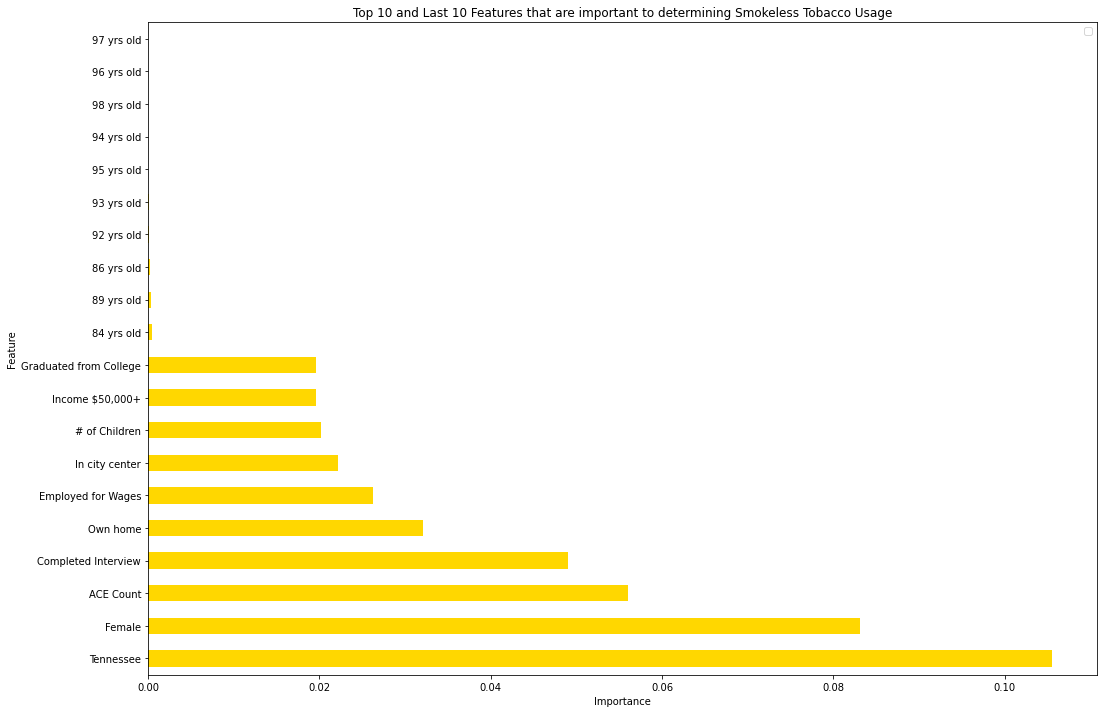

In [124]:
def top_bottom(df, color, labels):
  ''' Function to graph Top 10 and Last 10 Features based on importance'''
  full_df = pd.merge(df.head(10), df.tail(10), how='outer')
  full_df.plot(kind='barh', figsize=(17, 12), color=color)
  plt.yticks(ticks=full_df.index, labels=labels)
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.legend([]);
  return

top_bottom(tobacco_all, color = 'gold', labels=['Tennessee', 'Female', 'ACE Count', 'Completed Interview', 'Own home', 
            'Employed for Wages', 'In city center', '# of Children', 
            'Income $50,000+', 'Graduated from College',
            '84 yrs old', '89 yrs old', '86 yrs old', '92 yrs old', '93 yrs old',
            '95 yrs old', '94 yrs old', '98 yrs old', '96 yrs old', '97 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Smokeless Tobacco Usage');

plt.savefig('tobacco.jpg')

In [63]:
# getting features selected by 'selectkbest' for other three y's
features_activity_all = pipe_all_activity.named_steps['selectkbest'].get_support(indices=True) 
features_health_all = pipe_all_health.named_steps['selectkbest'].get_support(indices=True) 
features_smoker_all = pipe_all_smoker.named_steps['selectkbest'].get_support(indices=True) 

In [64]:
# getting column names for features selected by 'selectkbest' for other three y's
X_cols_activity_all = X_all.columns.values[features_activity_all]
X_cols_health_all = X_all.columns.values[features_health_all]
X_cols_smoker_all = X_all.columns.values[features_smoker_all]

In [65]:
# getting each feature's importance for other three y's
coefs_activity_all = pipe_all_activity.named_steps['extratreesclassifier'].feature_importances_
coefs_health_all = pipe_all_health.named_steps['randomforestclassifier'].feature_importances_
coefs_smoker_all = pipe_all_smoker.named_steps['randomforestclassifier'].feature_importances_

In [66]:
# feature importances for activity limitations
activity_all = pd.DataFrame({'features': X_cols_activity_all, 'importance':coefs_activity_all})
activity_all = activity_all.sort_values('importance', ascending = False)
activity_all.head(10)

,features,importance
0,PHYSHLTH,0.064612
28,EMPLOY_1.0,0.045376
12,_STATE_47.0,0.044890
3,ACE_Count,0.035991
34,RENTHOM1_1.0,0.032916
133,_INCOMG_5.0,0.028713
1,MENTHLTH,0.027984
37,SEX_2.0,0.024370
17,DISPCODE_1100.0,0.022246
22,MARITAL_1.0,0.019632


In [67]:
activity_all.tail(10)

,features,importance
47,_IMPAGE_23.0,0.000706
49,_IMPAGE_25.0,0.000692
42,_IMPAGE_18.0,0.000672
43,_IMPAGE_19.0,0.000646
44,_IMPAGE_20.0,0.000640
19,DISPCODE_1200.0,0.000570
116,_IMPAGE_95.0,0.000547
118,_IMPAGE_98.0,0.000272
115,_IMPAGE_94.0,0.000170
117,_IMPAGE_96.0,0.000088


**Looks like being very young or very old doesn't have much affect on activity limitations, nor does not finishing the survey in its entirety**

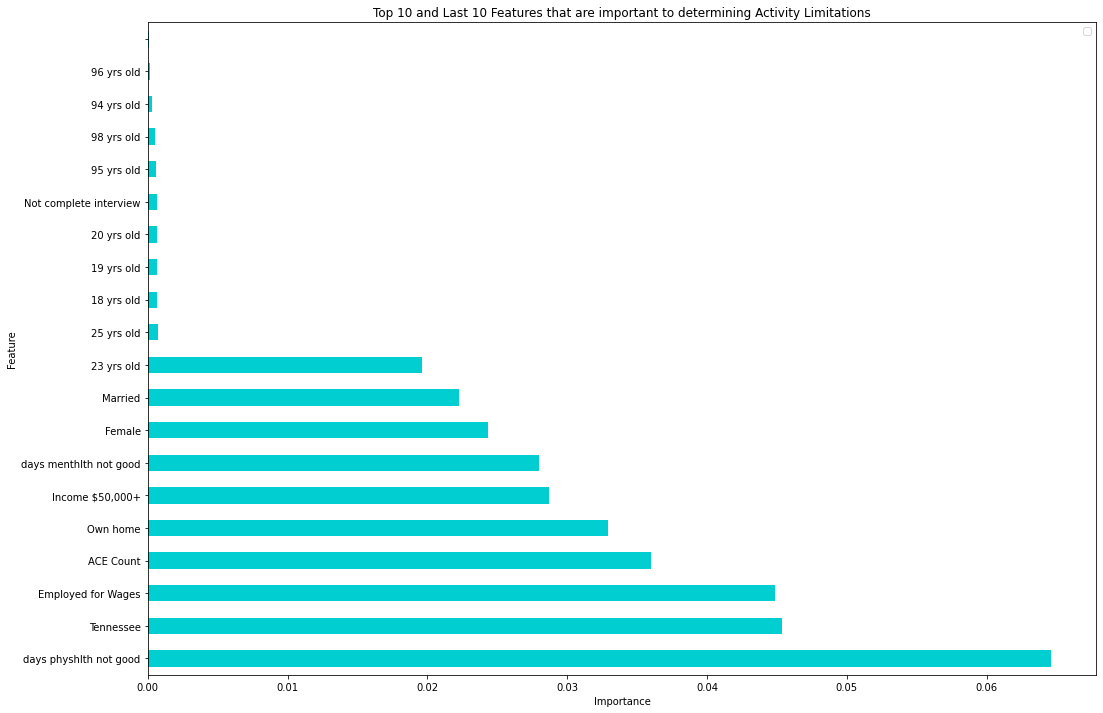

In [125]:
top_bottom(activity_all, color='darkturquoise', labels = ['days physhlth not good', 'Tennessee', 
                                                          'Employed for Wages', 'ACE Count', 'Own home', 
                                                          'Income $50,000+', 'days menthlth not good',
                                                          'Female', 'Married','23 yrs old', '25 yrs old', '18 yrs old',
                                                          '19 yrs old', '20 yrs old', 'Not complete interview',
                                                          '95 yrs old', '98 yrs old', '94 yrs old', '96 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Activity Limitations');

plt.savefig('activity.jpg')

In [70]:
# feature importances for self-reported health
health_all = pd.DataFrame({'features': X_cols_health_all, 'importance':coefs_health_all})
health_all = health_all.sort_values('importance', ascending = False)
health_all.head(10)

,features,importance
0,PHYSHLTH,0.098217
25,EMPLOY_1.0,0.050096
3,ACE_Count,0.041943
1,MENTHLTH,0.035647
103,_INCOMG_5.0,0.034179
33,SEX_2.0,0.029623
105,_TOTINDA_2.0,0.028867
30,RENTHOM1_1.0,0.027649
99,_EDUCAG_4.0,0.026682
34,MSCODE_1.0,0.025216


In [71]:
health_all.tail(10)

,features,importance
88,_IMPAGE_93.0,0.000693
43,_IMPAGE_27.0,0.000659
86,_IMPAGE_90.0,0.000623
47,_IMPAGE_31.0,0.000588
42,_IMPAGE_24.0,0.000492
46,_IMPAGE_30.0,0.000449
39,_IMPAGE_21.0,0.000422
40,_IMPAGE_22.0,0.000323
38,_IMPAGE_20.0,0.000295
37,_IMPAGE_18.0,0.000293


**Looks like a few ages don't have a big influence on perceived health, nor does being Native Hawaiian or other Pacific Islander**

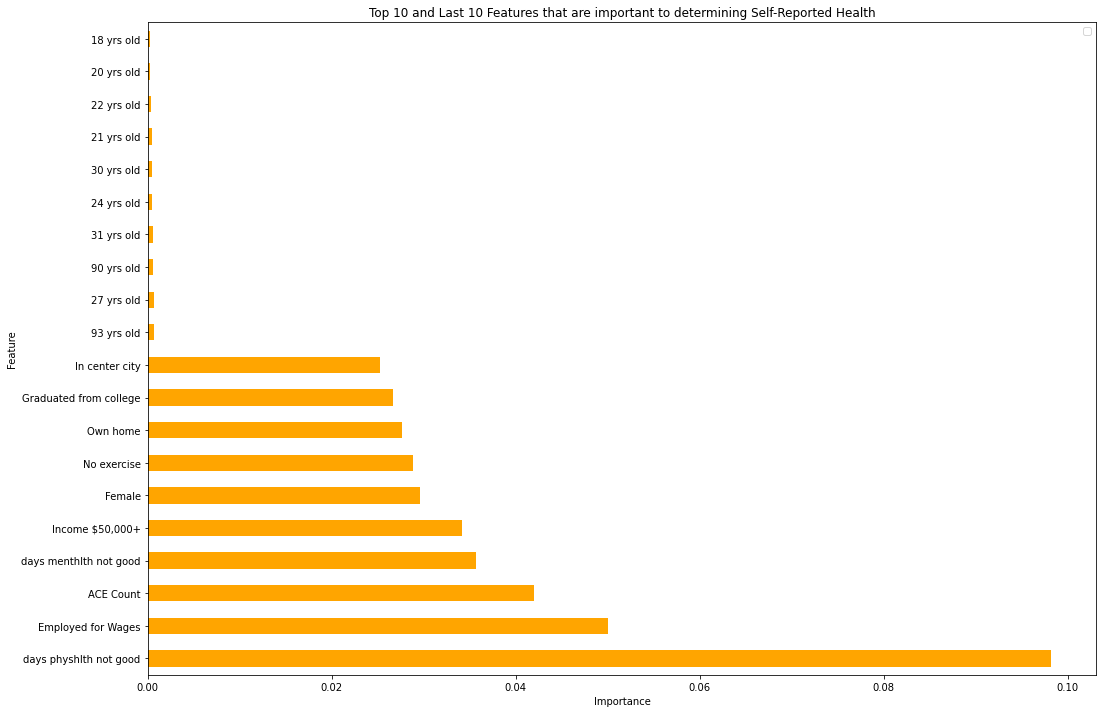

In [126]:
top_bottom(health_all, color = 'orange', labels = ['days physhlth not good', 'Employed for Wages',
                                                           'ACE Count', 'days menthlth not good',
                                                           'Income $50,000+','Female', 'No exercise',
                                                           'Own home', 'Graduated from college', 
                                                           'In center city','93 yrs old', '27 yrs old', '90 yrs old',
                                                           '31 yrs old', '24 yrs old', '30 yrs old', '21 yrs old',
                                                           '22 yrs old', '20 yrs old', '18 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Self-Reported Health');

plt.savefig('health.jpg')

In [76]:
# feature importances for smoker status
smoker_all = pd.DataFrame({'features': X_cols_smoker_all, 'importance':coefs_smoker_all})
smoker_all = smoker_all.sort_values('importance', ascending = False)
smoker_all.head(10)

,features,importance
3,ACE_Count,0.070129
0,PHYSHLTH,0.039350
1,MENTHLTH,0.036195
11,_STATE_47.0,0.034718
33,SEX_2.0,0.031440
2,CHILDREN,0.028594
24,EMPLOY_1.0,0.027645
30,RENTHOM1_1.0,0.026627
15,DISPCODE_1100.0,0.023800
36,MSCODE_5.0,0.023669


In [77]:
smoker_all.tail(10)

,features,importance
44,_IMPAGE_25.0,0.001406
86,_IMPAGE_87.0,0.001264
39,_IMPAGE_20.0,0.001125
40,_IMPAGE_21.0,0.001111
38,_IMPAGE_19.0,0.001087
85,_IMPAGE_86.0,0.001076
87,_IMPAGE_90.0,0.000995
89,_IMPAGE_92.0,0.000917
37,_IMPAGE_18.0,0.000901
88,_IMPAGE_91.0,0.000470


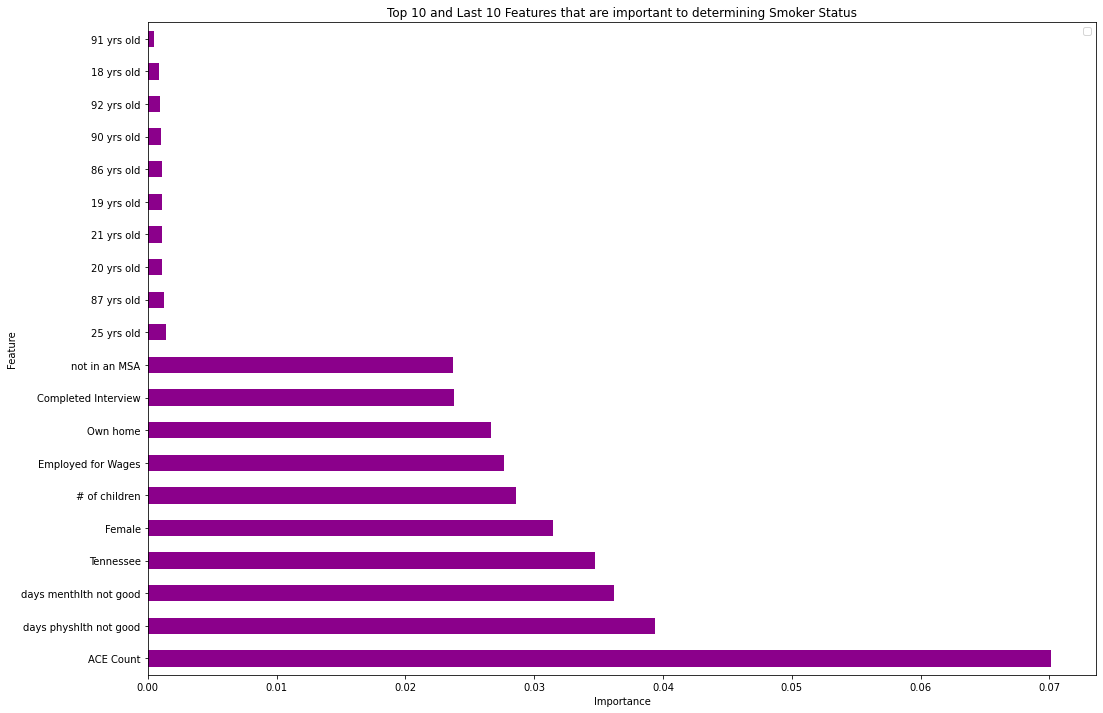

In [127]:
top_bottom(smoker_all, color='darkmagenta', labels = ['ACE Count','days physhlth not good', 'days menthlth not good',
                                                      'Tennessee', 'Female', '# of children', 'Employed for Wages', 'Own home',
                                                      'Completed Interview', 'not in an MSA', '25 yrs old', '87 yrs old', '20 yrs old',
                                                           '21 yrs old', '19 yrs old', '86 yrs old', '90 yrs old',
                                                           '92 yrs old', '18 yrs old', '91 yrs old'])
plt.title('Top 10 and Last 10 Features that are important to determining Smoker Status');

plt.savefig('smoker.jpg')

**Looks like a few ages don't have a big influence on smoker status**

In [79]:
X_ace = X_num[['ACE_Count']]

In [80]:
X_ace.head()

,ACE_Count
0,0
1,3
2,0
3,0
4,0


In [81]:
# creating the 4 y's for ACE count only
y_tobacco_ace = brfss_total['USENOW3']
y_activity_ace = brfss_total['QLACTLM2']
y_health_ace = brfss_total['_RFHLTH']
y_smoker_ace = brfss_total['_SMOKER3']

In [82]:
# to compensate for unbalanced classes in my y's will use SMOTE

sm = SMOTE(random_state=151)
X1, y_tobacco_ace = sm.fit_resample(X_ace, y_tobacco_ace)

sm2 = SMOTE(random_state=151)
X2, y_activity_ace = sm2.fit_resample(X_ace, y_activity_ace)

sm3 = SMOTE(random_state=151)
X3, y_health_ace = sm3.fit_resample(X_ace, y_health_ace)

sm4 = SMOTE(random_state=151)
X4, y_smoker_ace = sm4.fit_resample(X_ace, y_smoker_ace)

In [83]:
X1.shape

(454496, 1)

In [84]:
# creating training and testing sets for all ACE count y's 
X_train_ace, X_test_ace, y_train_tobacco_ace, y_test_tobacco_ace = train_test_split(X1, y_tobacco_ace, random_state = 151, stratify=y_tobacco_ace)
X_train_ace2, X_test_ace2, y_train_activity_ace, y_test_activity_ace = train_test_split(X2, y_activity_ace, random_state = 151, stratify=y_activity_ace)
X_train_ace3, X_test_ace3, y_train_health_ace, y_test_health_ace = train_test_split(X3, y_health_ace, random_state = 151, stratify=y_health_ace)
X_train_ace4, X_test_ace4, y_train_smoker_ace, y_test_smoker_ace = train_test_split(X4, y_smoker_ace, random_state = 151, stratify=y_smoker_ace)

In [85]:
ace_tobacco = xgb.XGBClassifier(learning_rate = 0.5, max_depth = 3, n_estimators = 20)
ace_tobacco.fit(X_train_ace, y_train_tobacco_ace)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
ace_activity = RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 100)
ace_activity.fit(X_train_ace2, y_train_activity_ace)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
ace_health = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500)
ace_health.fit(X_train_ace3, y_train_health_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=500,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [88]:
ace_smoker = ExtraTreesClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 300)
ace_smoker.fit(X_train_ace4, y_train_smoker_ace)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=300,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [89]:
tobacco_ace_preds = ace_tobacco.predict(X_test_ace)
activity_ace_preds = ace_activity.predict(X_test_ace2)
health_ace_preds = ace_health.predict(X_test_ace3)
smoker_ace_preds = ace_smoker.predict(X_test_ace4)

tobacco_ace_prec = precision_score(y_test_tobacco_ace, tobacco_ace_preds, average='micro')
activity_ace_prec = precision_score(y_test_activity_ace, activity_ace_preds, average='micro')
health_ace_prec = precision_score(y_test_health_ace, health_ace_preds, average='micro')
smoker_ace_prec = precision_score(y_test_smoker_ace, smoker_ace_preds, average='micro')

In [90]:
print(f'training accuracy for tobacco w/ACE Grouped: {ace_tobacco.score(X_train_ace, y_train_tobacco_ace)}')
print(f'testing accuracy for tobacco w/ACE Grouped: {ace_tobacco.score(X_test_ace, y_test_tobacco_ace)}')
print(f'Precision for tobacco: {tobacco_ace_prec}')

training accuracy for tobacco w/ACE Grouped: 0.38935729540707364
testing accuracy for tobacco w/ACE Grouped: 0.3859131873547842
Precision for tobacco: 0.3859131873547842


In [91]:
print(f'training accuracy for activity w/ACE Grouped: {ace_activity.score(X_train_ace2, y_train_activity_ace)}')
print(f'testing accuracy for activity w/ACE Grouped: {ace_activity.score(X_test_ace2, y_test_activity_ace)}')
print(f'Precision for activity: {activity_ace_prec}')

training accuracy for activity w/ACE Grouped: 0.4146498011835061
testing accuracy for activity w/ACE Grouped: 0.417148045523568
Precision for activity: 0.417148045523568


In [92]:
print(f'training accuracy for health w/ACE Grouped: {ace_health.score(X_train_ace3, y_train_health_ace)}')
print(f'testing accuracy for health w/ACE Grouped: {ace_health.score(X_test_ace3, y_test_health_ace)}')
print(f'Precision for health: {health_ace_prec}')

training accuracy for health w/ACE Grouped: 0.3728155249700693
testing accuracy for health w/ACE Grouped: 0.3759692620383389
Precision for health: 0.3759692620383389


In [93]:
print(f'training accuracy for smoker w/ACE Grouped: {ace_smoker.score(X_train_ace4, y_train_smoker_ace)}')
print(f'testing accuracy for smoker w/ACE Grouped: {ace_smoker.score(X_test_ace4, y_test_smoker_ace)}')
print(f'Precision for smoker: {smoker_ace_prec}')

training accuracy for smoker w/ACE Grouped: 0.2730131391813781
testing accuracy for smoker w/ACE Grouped: 0.27195271522141906
Precision for smoker: 0.27195271522141906




---




**Since we're only looking at one feature, the amount of ACEs someone had, to predict the y's, I believe logistic regression to be the best course of action when modeling. It is simple and easy to understand, something that is an asset when talking about such a sensitive topic. Also, the accuracy and precision for each y is comprable to those for the ensemble models above, differing the most for smokeless tobacco usage.**

---



In [94]:
ace_tobacco_lr = LogisticRegression(C=0.01)
ace_tobacco_lr.fit(X_train_ace, y_train_tobacco_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
ace_activity_lr = LogisticRegression(C=0.01)
ace_activity_lr.fit(X_train_ace2, y_train_activity_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
ace_health_lr = LogisticRegression(C=0.01)
ace_health_lr.fit(X_train_ace3, y_train_health_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
ace_smoker_lr = LogisticRegression(C=0.01)
ace_smoker_lr.fit(X_train_ace4, y_train_smoker_ace)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [98]:
tobacco_ace_preds_lr = ace_tobacco_lr.predict(X_test_ace)
activity_ace_preds_lr = ace_activity_lr.predict(X_test_ace2)
health_ace_preds_lr = ace_health_lr.predict(X_test_ace3)
smoker_ace_preds_lr = ace_smoker_lr.predict(X_test_ace4)

tobacco_ace_prec_lr = precision_score(y_test_tobacco_ace, tobacco_ace_preds_lr, average='micro')
activity_ace_prec_lr = precision_score(y_test_activity_ace, activity_ace_preds_lr, average='micro')
health_ace_prec_lr = precision_score(y_test_health_ace, health_ace_preds_lr, average='micro')
smoker_ace_prec_lr = precision_score(y_test_smoker_ace, smoker_ace_preds_lr, average='micro')

In [99]:
print(f'Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: {ace_tobacco_lr.score(X_train_ace, y_train_tobacco_ace)}')
print(f'Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: {ace_tobacco_lr.score(X_test_ace, y_test_tobacco_ace)}')
print(f'Logistic Regression precision for smokeless tobacco usage w/ACE grouped: {tobacco_ace_prec_lr}')

Logistic Regression training accuracy for smokeless tobacco usage w/ACE grouped: 0.37374146307118217
Logistic Regression testing accuracy for smokeless tobacco usage w/ACE grouped: 0.3732046046609871
Logistic Regression precision for smokeless tobacco usage w/ACE grouped: 0.3732046046609871


In [100]:
print(f'Logistic Regression training accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_train_ace2, y_train_activity_ace)}')
print(f'Logistic Regression testing accuracy for activity limitations w/ACE grouped: {ace_activity_lr.score(X_test_ace2, y_test_activity_ace)}')
print(f'Logistic Regression precision for activity limitations w/ACE grouped: {activity_ace_prec_lr}')

Logistic Regression training accuracy for activity limitations w/ACE grouped: 0.39769038897064196
Logistic Regression testing accuracy for activity limitations w/ACE grouped: 0.4002880445842922
Logistic Regression precision for activity limitations w/ACE grouped: 0.4002880445842922


In [101]:
print(f'Logistic Regression training accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_train_ace3, y_train_health_ace)}')
print(f'Logistic Regression testing accuracy for self-reported health w/ACE grouped: {ace_health_lr.score(X_test_ace3, y_test_health_ace)}')
print(f'Logistic Regression precision for self-reported health w/ACE grouped: {health_ace_prec_lr}')

Logistic Regression training accuracy for self-reported health w/ACE grouped: 0.3632562715199213
Logistic Regression testing accuracy for self-reported health w/ACE grouped: 0.3658764077791544
Logistic Regression precision for self-reported health w/ACE grouped: 0.3658764077791544


In [102]:
print(f'Logistic Regression training accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_train_ace4, y_train_smoker_ace)}')
print(f'Logistic Regression testing accuracy for smoker status w/ACE grouped: {ace_smoker_lr.score(X_test_ace4, y_test_smoker_ace)}')
print(f'Logistic Regression precision for smoker w/ACE grouped: {smoker_ace_prec_lr}')

Logistic Regression training accuracy for smoker status w/ACE grouped: 0.2615223357384864
Logistic Regression testing accuracy for smoker status w/ACE grouped: 0.26244095926515487
Logistic Regression precision for smoker w/ACE grouped: 0.26244095926515487


In [103]:
# getting the coefficient for each tobacco class
coef_dk_tobacco = ace_tobacco_lr.coef_[0]
coef_everyday_tobacco = ace_tobacco_lr.coef_[1]
coef_somedays_tobacco = ace_tobacco_lr.coef_[2]
coef_notatall = ace_tobacco_lr.coef_[3]

# converting the log odds for each tobacco class into regular odds for interpretation
odds_dk_tobacco = np.exp(coef_dk_tobacco)
odds_everyday_tobacco = np.exp(coef_everyday_tobacco)
odds_somedays_tobacco = np.exp(coef_somedays_tobacco)
odds_notatall = np.exp(coef_notatall)

# putting converted odds into a dataframe
tobacco_coefs = pd.DataFrame([odds_dk_tobacco, odds_everyday_tobacco, odds_somedays_tobacco, odds_notatall], 
             index=['do not know', 'every day', 'some days', 'not at all'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
tobacco_coefs

,coef
some days,1.239700
every day,1.211356
not at all,1.192229
do not know,0.558537


In [104]:
# getting the coefficient for each smoker class
coef_dk_activity = ace_activity_lr.coef_[0]
coef_yes_activity = ace_activity_lr.coef_[1]
coef_no_activity = ace_activity_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_activity = np.exp(coef_dk_activity)
odds_yes_activity = np.exp(coef_yes_activity)
odds_no_activity = np.exp(coef_no_activity)

# putting converted odds into a dataframe
activity_coefs = pd.DataFrame([odds_dk_activity, odds_yes_activity, odds_no_activity], 
             index=['do not know', 'yes', 'no'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
activity_coefs

,coef
yes,1.079552
no,0.977599
do not know,0.947536


In [105]:
# getting the coefficient for each smoker class
coef_dk_health = ace_health_lr.coef_[0]
coef_good_better_health = ace_health_lr.coef_[1]
coef_fair_poor_health = ace_health_lr.coef_[2]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk_health = np.exp(coef_dk_health)
odds_good_better_health = np.exp(coef_good_better_health)
odds_fair_poor_health = np.exp(coef_fair_poor_health)

# putting converted odds into a dataframe
health_coefs = pd.DataFrame([odds_dk_health, odds_good_better_health, odds_fair_poor_health], 
             index=['do not know', 'Good or Better', 'Fair or Poor'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
health_coefs

,coef
Fair or Poor,1.053366
do not know,0.975238
Good or Better,0.973443


In [106]:
# got information about converting odds from https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1

# getting the coefficient for each smoker class
coef_dk = ace_smoker_lr.coef_[0]
coef_everyday = ace_smoker_lr.coef_[1]
coef_somedays = ace_smoker_lr.coef_[2]
coef_former = ace_smoker_lr.coef_[3]
coef_never = ace_smoker_lr.coef_[4]

# converting the log odds for each smoker class into regular odds for interpretation
odds_dk = np.exp(coef_dk)
odds_everyday = np.exp(coef_everyday)
odds_somedays = np.exp(coef_somedays)
odds_former = np.exp(coef_former)
odds_never = np.exp(coef_never)

# putting converted odds into a dataframe
smoker_coefs = pd.DataFrame([odds_dk, odds_everyday, odds_somedays, odds_former, odds_never], 
             index=['do not know', 'every day', 'some days', 'former', 'never'], 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)
smoker_coefs

,coef
every day,1.117938
some days,1.087797
former,1.012040
never,0.946684
do not know,0.858285


In [107]:
def coef_interpret(data):

  '''Function to interpret multiclass logistic regression coefficients. 
  Coefficient interpretation guidance came from http://www.columbia.edu/~so33/SusDev/Lecture_10.pdf

  data: a dataframe that only includes y classes, as an index, on only coefficients for each class

  '''
  for response, row in zip(data.index, data['coef']):
    if row > 1:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class INCREASES by {(row - 1)*100}% when all other variables are held constant.')
    else:
      print(f'For every one-unit increase in the number of ACEs someone has, the odds that a person is in the {response} class DECREASES by {(1-row)*100}% when all other variables are held constant.')
  return

In [108]:
print(f'Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?')
coef_interpret(tobacco_coefs)

Do you currently use chewing tobacco, snuff, or snus every day, some days, or not at all?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 23.96998826360548% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 21.13557934535446% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the not at all class INCREASES by 19.222936781581957% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 44.14630569630712% when all other variables are held constant.


In [109]:
print(f'Are you limited in any way in any activities because of physical, mental, or emotional problems?')
coef_interpret(activity_coefs)

Are you limited in any way in any activities because of physical, mental, or emotional problems?
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the yes class INCREASES by 7.95519333174215% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the no class DECREASES by 2.2401451724557764% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 5.246357826538361% when all other variables are held constant.


In [110]:
print(f'Adults with good or better health vs. fair or poor health')
coef_interpret(health_coefs)

Adults with good or better health vs. fair or poor health
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Fair or Poor class INCREASES by 5.336561180571686% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 2.4762373158712214% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the Good or Better class DECREASES by 2.655725040518031% when all other variables are held constant.


In [111]:
print(f'Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers')
coef_interpret(smoker_coefs)

Four-level smoker status: Every day smokers, Some days smokers, Former smokers, Non-smokers
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the every day class INCREASES by 11.793819939463312% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the some days class INCREASES by 8.779749711025286% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the former class INCREASES by 1.203966667524825% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the never class DECREASES by 5.331606902778551% when all other variables are held constant.
For every one-unit increase in the number of ACEs someone has, the odds that a person is in the do not know class DECREASES by 14.171483039763288% when all other 